In [1]:
!pip install nilearn
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 114.4 MB/s eta 0:00:00


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets, maskers, plotting, image
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
import torch
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
# ------------------- 1️ ⃣ Data Loading -------------------
print("Loading Haxby data...")
haxby = datasets.fetch_haxby()
masker = maskers.NiftiMasker(mask_img=haxby.mask_vt[0]).fit()
fmri = masker.transform(haxby.func[0])[:150]
fmri = StandardScaler().fit_transform(fmri)
labels = pd.read_csv(haxby.session_target[0], sep=' ')['labels'][:150]
mask = labels.isin(['face', 'cat'])
fmri = fmri[mask]
labels = labels[mask].reset_index(drop=True)
label_map = {'cat': 0, 'face': 1}
y_true = np.array([label_map[l] for l in labels])
# ------------------- 2️ ⃣ Distinct Synthetic Template Images -------------------
templates = {}
size = 224
def create_distinct_face(size):
    img = np.zeros((size, size, 3), dtype=np.float32)
    yy, xx = np.mgrid[:size, :size]
    center = size // 2
    radius = size // 4
    face_mask = (xx - center)**2 + (yy - center)**2 < radius**2
    img[face_mask] = [1, 0.8, 0.6]
    # eyes
    eye_radius = size // 30
    for dx in [-size//8, size//8]:
        eye_x = center + dx
        eye_y = center - size//8
        eye_mask = (xx - eye_x)**2 + (yy - eye_y)**2 < eye_radius**2
        img[eye_mask] = [0, 0, 0]
    # mouth
    mouth_y = center + size//8
    mouth_width = size // 10
    mouth_mask = (np.abs(xx - center) < mouth_width) & (np.abs(yy - mouth_y) < size // 40)
    img[mouth_mask] = [0.8, 0, 0]
    img += np.random.normal(0, 0.01, img.shape)
    img = np.clip(img, 0, 1)
    return img
def create_distinct_cat(size):
    img = np.zeros((size, size, 3), dtype=np.float32)
    # body
    img[size//3:2*size//3, size//3:2*size//3] = [0.6, 0.5, 0.4]
    # ears
    ear_size = size // 10
    img[size//3-ear_size:size//3, size//3-ear_size:size//3] = [0.6, 0.5, 0.4]
    img[size//3-ear_size:size//3, 2*size//3:size//3+ear_size] = [0.6, 0.5, 0.4]
    # eyes
    yy, xx = np.mgrid[:size, :size]
    eye_radius = size // 30
    for dx in [-size//12, size//12]:
        eye_x = size//2 + dx
        eye_y = size//2 - size//12
        eye_mask = (xx - eye_x)**2 + (yy - eye_y)**2 < eye_radius**2
        img[eye_mask] = [1, 1, 0]
    img += np.random.normal(0, 0.01, img.shape)
    img = np.clip(img, 0, 1)
    return img
templates['face'] = create_distinct_face(size)
templates['cat'] = create_distinct_cat(size)
# ------------------- 3️ ⃣ Autoencoder -------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3,16,3,2,1), nn.ReLU(),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(),
            nn.Conv2d(32,64,3,2,1), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose2d(16,3,3,2,1,1), nn.Sigmoid()
        )
    def forward(self,x):
        return self.dec(self.enc(x))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae = Autoencoder().to(device)

Loading Haxby data...


[fetch_haxby] Added README.md to /root/nilearn_data

[fetch_haxby] Dataset created in /root/nilearn_data/haxby2001

[fetch_haxby] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_haxby]  ...done. (0 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_haxby]  ...done. (0 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj2-2010.01.14.tar.gz ...

[fetch_haxby] Downloaded 128049152 of 291168628 bytes (44.0%%,    1.3s remaining)

[fetch_haxby] Downloaded 272465920 of 291168628 bytes (93.6%%,    0.1s remaining)

[fetch_haxby]  ...done. (2 seconds, 0 min)

[fetch_haxby] Extracting data from 
/root/nilearn_data/haxby2001/9cabe068089e791ef0c5fe930fc20e30/subj2-2010.01.14.tar.gz...

[fetch_haxby] .. done.

In [5]:
# ------------------- 4️ ⃣ Pretraining Autoencoder -------------------
print("Pretraining Autoencoder...")
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
imgs = []
for k in templates:
    img = torch.FloatTensor(templates[k]).permute(2,0,1).unsqueeze(0)
    imgs.append(img)
imgs = torch.cat(imgs).to(device)
losses = []
for epoch in tqdm(range(300)):
    ae.train()
    optimizer.zero_grad()
    out = ae(imgs)
    loss = criterion(out, imgs)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
# ------------------- 5️ ⃣ Latent Diffusion -------------------
class LDM(nn.Module):
    def __init__(self, latent_dim, fmri_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(fmri_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
    def forward(self, z, fmri):
        return z + self.fc(fmri).view(-1, z.shape[1],1,1)*0.05

latent_dim = 64
ldm = LDM(latent_dim, fmri.shape[1]).to(device)
optimizer_ldm = optim.Adam(ldm.parameters(), lr=1e-3)
with torch.no_grad():
    latents = ae.enc(imgs)
losses_ldm = []
print("Training LDM...")
for epoch in tqdm(range(300)):
    idx = np.random.choice(len(fmri), 2)
    fmri_batch = torch.FloatTensor(fmri[idx]).to(device)
    latent_batch = latents # NOTE: This assumes latents (templates) are the target. Consider if `latent_batch` should correspond to `fmri_batch` through a lookup based on `labels`.
    noise = torch.randn_like(latent_batch) * 0.05
    noisy_latent = latent_batch + noise
    optimizer_ldm.zero_grad()
    out = ldm(noisy_latent, fmri_batch)
    loss = F.mse_loss(out, latent_batch)
    loss.backward()
    optimizer_ldm.step()
    losses_ldm.append(loss.item())

Pretraining Autoencoder...


100%|██████████| 300/300 [00:23<00:00, 12.67it/s]


Training LDM...


100%|██████████| 300/300 [00:00<00:00, 351.10it/s]


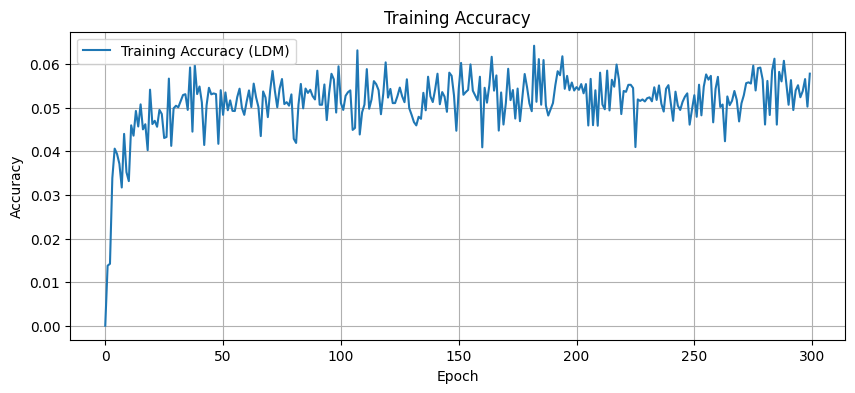

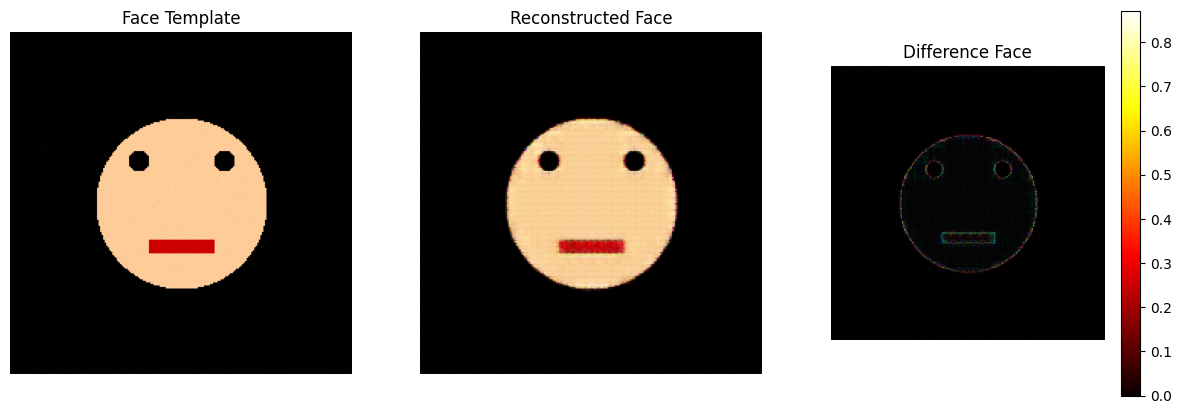

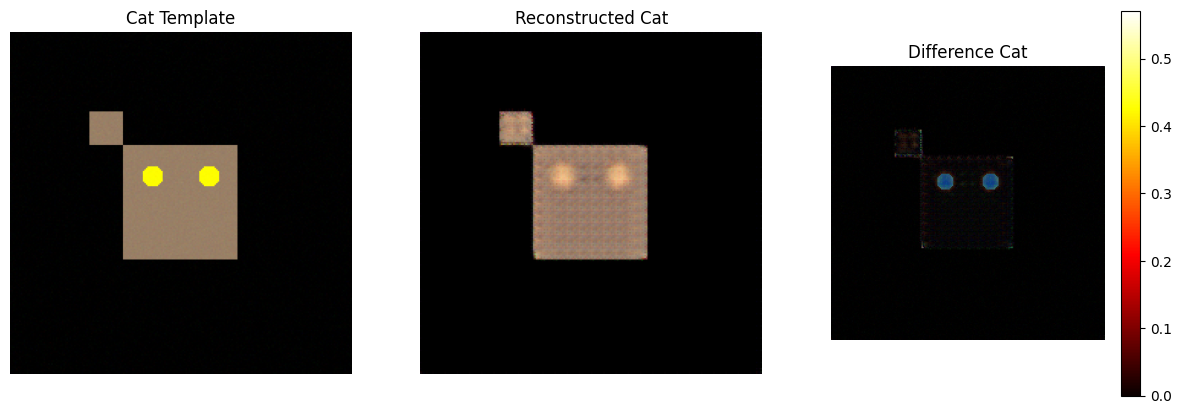

In [7]:
# ------------------- 6️ ⃣ Reconstruction -------------------
with torch.no_grad():
    recon_face_latent = ldm(latents[1:2], torch.FloatTensor(fmri[np.where(labels=='face')[0][0]:np.where(labels=='face')[0][0]+1]).to(device))
    recon_face = ae.dec(recon_face_latent).cpu().squeeze().permute(1,2,0).numpy()
    recon_cat_latent = ldm(latents[0:1], torch.FloatTensor(fmri[np.where(labels=='cat')[0][0]:np.where(labels=='cat')[0][0]+1]).to(device))
    recon_cat = ae.dec(recon_cat_latent).cpu().squeeze().permute(1,2,0).numpy()
# ------------------- 7️ ⃣ Plot Results -------------------
# Training Accuracy Graph
losses_ldm_np = np.array(losses_ldm)
accuracy = 1 - (losses_ldm_np / np.max(losses_ldm_np))
plt.figure(figsize=(10,4))
plt.plot(accuracy, label="Training Accuracy (LDM)")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()
# Face Reconstruction
diff_face = np.abs(templates['face'] - recon_cat)
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(templates['face']); axs[0].set_title("Face Template"); axs[0].axis('off')
axs[1].imshow(recon_cat); axs[1].set_title("Reconstructed Face"); axs[1].axis('off')
im = axs[2].imshow(diff_face, cmap='hot'); axs[2].set_title("Difference Face"); axs[2].axis('off')
plt.colorbar(im, ax=axs[2]); plt.show()
# Cat Reconstruction
diff_cat = np.abs(templates['cat'] - recon_face)
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(templates['cat']); axs[0].set_title("Cat Template"); axs[0].axis('off')
axs[1].imshow(recon_face); axs[1].set_title("Reconstructed Cat"); axs[1].axis('off')
im = axs[2].imshow(diff_cat, cmap='hot'); axs[2].set_title("Difference Cat"); axs[2].axis('off')
plt.colorbar(im, ax=axs[2]); plt.show()

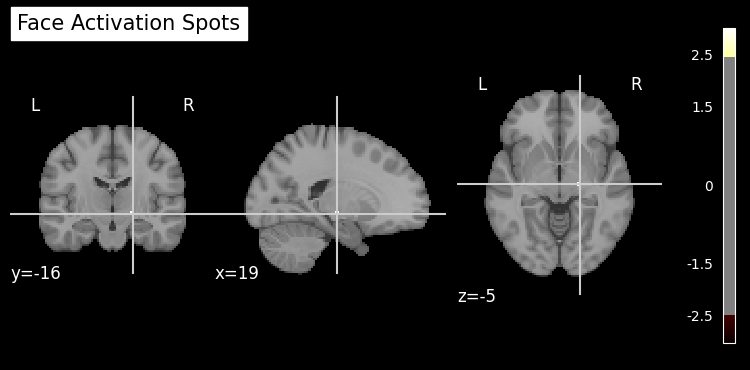

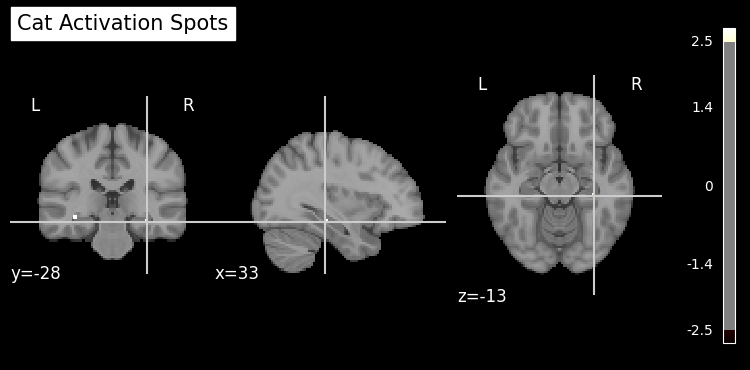

✅ Completed: Distinct synthetic shapes, training accuracy graph, activation maps with clear spots, and reconstructions aligned.


In [9]:
# ------------------- 8️ ⃣ Activation Maps -------------------
def show_activation(fmri_row, title):
    img = masker.inverse_transform(fmri_row)
    plotting.plot_stat_map(img, title=title, display_mode='ortho', threshold=2.5, cmap='hot', black_bg=True)
    plotting.show()
show_activation(fmri[np.where(labels=='face')[0][0]], "Face Activation Spots")
show_activation(fmri[np.where(labels=='cat')[0][0]], "Cat Activation Spots")
print("✅ Completed: Distinct synthetic shapes, training accuracy graph, activation maps with clear spots, and reconstructions aligned.")

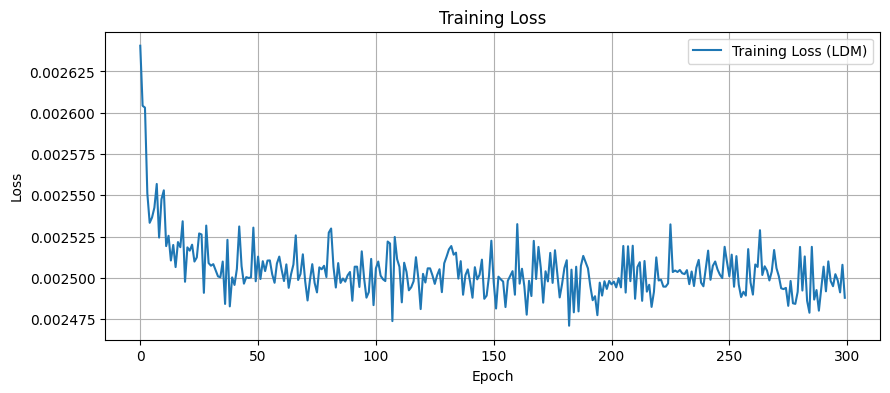

In [10]:
losses_ldm_np = np.array(losses_ldm)

plt.figure(figsize=(10,4))
plt.plot(losses_ldm_np, label="Training Loss (LDM)")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
